In [1]:
# Importing libraries
# Importing model
import sys
sys.path.append("..")
from jnk3_noask1.model_analysis.jnk3_no_ask1 import model
import numpy as np
import matplotlib.pyplot as plt
from pysb.simulator import ScipyOdeSimulator
import pandas as pd
from jnk3_noask1.model_analysis.equilibration_function import pre_equilibration


/Users/dionisio/anaconda/envs/nicole/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading fitted parameters
param_values = np.array([p.value for p in model.parameters])
idx_pars_calibrate = [1, 15, 17, 19, 24, 25, 26, 27]
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

fitted_pars = np.load('../jnk3_noask1/model_analysis/pydream_most_likely_par.npy')
# param_values[rates_of_interest_mask] = 10 ** fitted_pars

exp_data = pd.read_csv('../data/exp_data_arrestin_normalization_1h_138max.csv')

ignore = 1

# Index of Initial conditions of Arrestin
arrestin_idx = [32]
jnk3_initial_value = 0.6  # total jnk3
jnk3_initial_idxs = [35, 36, 37]

In [3]:
# Simulating model

tspan = np.linspace(0, exp_data['Time (secs)'].values[-(ignore+1)], 121)
t_exp_mask = [idx in exp_data['Time (secs)'].values[:-1] for idx in tspan]
solver = ScipyOdeSimulator(model, tspan=tspan)

In [8]:
# Function to display experimental data and the
# simulated model trajectories

def display(position):
    Y = np.copy(position)
    param_values[rates_of_interest_mask] = 10 ** Y

    pars1 = np.copy(param_values)
    pars2 = np.copy(param_values)

    # Pre-equilibration
    time_eq = np.linspace(0, 30, 30)
    pars_eq1 = np.copy(param_values)
    pars_eq2 = np.copy(param_values)

    pars_eq2[arrestin_idx] = 0
    pars_eq2[jnk3_initial_idxs] = [0.492, 0.108, 0]

    all_pars = np.stack((pars_eq1, pars_eq2))
    all_pars[:, [24, 25]] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc = pre_equilibration(model, time_eq, all_pars)[1]

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    pars2[arrestin_idx] = 0
    pars2[jnk3_initial_idxs] = [0.492, 0.108, 0]
    sim = solver.run(param_values=[pars1, pars2], initials=eq_conc).all

    plt.plot(tspan, sim[0]['pTyr_jnk3'] / jnk3_initial_value, color='red')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pTyr_arrestin_avg'].values[:-ignore],
                 exp_data['pTyr_arrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='red', label='p(Tyr)JNK3 exp')
    plt.plot(tspan, sim[0]['pThr_jnk3'] / jnk3_initial_value, color='blue')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pThr_arrestin_avg'].values[:-ignore],
                 exp_data['pThr_arrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='blue', label='p(Thr)JNK3 exp')


    plt.plot(tspan, sim[1]['pTyr_jnk3'] / jnk3_initial_value, color='black')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pTyr_noarrestin_avg'].values[:-ignore],
                 exp_data['pTyr_noarrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='black', label='p(Tyr)JNK3 -Arr exp')
    plt.plot(tspan, sim[1]['pThr_jnk3'] / jnk3_initial_value, color='green')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pThr_noarrestin_avg'].values[:-ignore],
                 exp_data['pThr_noarrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='green', label='p(Thr)JNK3 -Arr exp')

    plt.xlabel('Time (s)')
    plt.ylabel('pJNK3 (microM)')
    plt.legend()
#     plt.savefig('jnk3_noASK1_trained_pso_1h.png')
    plt.show()

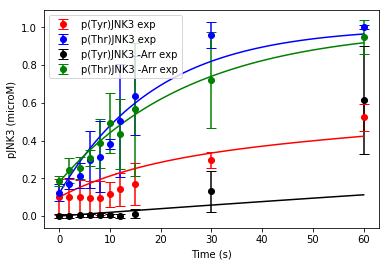

In [9]:
display(fitted_pars)